In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import re

In [2]:
taxonomy_deep = pd.read_pickle('preprocessed_data/rarefied_kraken_species_level_taxonomy_filtered_ra.pkl')

# blood = pd.read_pickle('preprocessed_data/blood_measurments_preprocessed.pkl')
# blood = blood.rename(columns= lambda x: re.sub('_result_all_m_1','',x))

# blood_metabolites = pd.read_pickle('preprocessed_data/blood_metabolites_preprocessed.pkl')

In [3]:
def vis_pred(pred, y):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.histplot(pred, ax=axes[0], label='Predictions', color='blue', kde=False, bins=30, stat='density')
    sns.histplot(y, ax=axes[0], label='Targets', color='orange', kde=False, bins=30, stat='density')

    axes[0].set_title(f'{m_name}')
    axes[0].set_xlabel(f'{m_name} Value')
    axes[0].set_ylabel('Density')
    axes[0].legend()

    min_v, max_v = min(pred.min(), y.min()), max(pred.max(), y.max())

    axes[1].set_xlim((min_v, max_v))
    axes[1].set_ylim((min_v, max_v))

    axes[1].scatter(x=y, y=pred)
    axes[1].plot([min_v, max_v], [min_v, max_v], linestyle='--', color='red')


    axes[1].set_title(m_name)
    axes[1].set_xlabel(f'Target')

    plt.tight_layout()
    plt.show()

### Variable information is available here:

In [4]:
vo = pd.read_csv("/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/metadata/variable_overview.csv")


## Let's load relevant data & metadata: age, gender, bmi:

In [5]:
deep_link = pd.read_csv("/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/metadata/OV22_00666_deep_linkage_file-v2.csv")
a1v2 = pd.read_csv("/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/metadata/1a_v_2_results_filtered_to_deep.csv")
age_gender = pd.merge(a1v2[['age','gender','project_pseudo_id']], deep_link,  on = "project_pseudo_id",how='inner').set_index('LLDEEP_ID')[['age','gender']]
age_gender = age_gender.groupby(age_gender.index).first()
vo = pd.read_csv("/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/metadata/variable_overview.csv")
blood_vo = vo[(vo["subsection"] == "Biospecimen: Blood") & (vo["1a_v_2"] == "x")]["variable_name"].values
a1v2 = pd.merge(a1v2, deep_link,  on = "project_pseudo_id",how='inner')
blood = a1v2.set_index('LLDEEP_ID')[blood_vo]
blood = blood.replace(to_replace={'$5':'nan'}).astype(float)

In [6]:
a1v1 = pd.read_csv("/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/talbamberger/metadata/1a_v_1_results_filtered_to_deep.csv")
# deep_link = pd.read_csv(“metadata/OV22_00666_deep_linkage_file-v2.csv”)
a1v1_link = pd.merge(a1v1, deep_link, how="inner", on="project_pseudo_id")
bmi_data = a1v1_link.set_index('LLDEEP_ID')[['bodylength_cm_all_m_1','bodyweight_kg_all_m_1']]
bmi_data = bmi_data.groupby(bmi_data.index).median()
#  BMI = weight (kg) ÷ height2 (meters)
bmi_data['bmi'] = bmi_data['bodyweight_kg_all_m_1'] / ((bmi_data['bodylength_cm_all_m_1'] / 100) ** 2)
bmi_data['bmi_score'] = np.where(
        (bmi_data['bmi'] >= 18.5) & (bmi_data['bmi'] <= 25),0,
        np.where((bmi_data['bmi'] > 25) & (bmi_data['bmi'] <= 30),0.5,
            np.where(bmi_data['bmi'] < 18.5,1,1)))

/local/3532766/ipykernel_21966/642269102.py:1: DtypeWarning: Columns (7,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,87,88,89,90,91,92,93,94,97,98,99,100,101,102,103,104,107,108,109,110,111,112,113,114,117,118,119,120,121,122,123,124,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,195,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,259,366,367,368,369,370,371,423,424,425,426,427,428,446,447,449,450,451,452,453,454,455,456,457,458,459,460,461,462,464,465,466,467,470,475) have mixed types. Specify dtype option on import or set low_memory=False.
  a1v1 = pd.read_csv("/groups/umcg-lifeli

<Axes: ylabel='Frequency'>

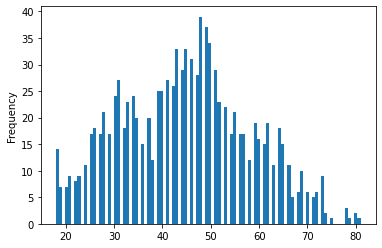

In [7]:
age_gender['age'].plot.hist(bins=100)

In [8]:
age_gender['gender'].value_counts() / age_gender.shape[0]

gender
FEMALE    0.579502
MALE      0.420498
Name: count, dtype: float64

<Axes: ylabel='Frequency'>

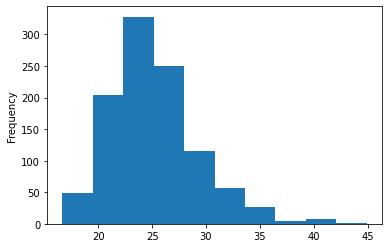

In [9]:
bmi_data['bmi'].plot.hist()

<Axes: ylabel='Frequency'>

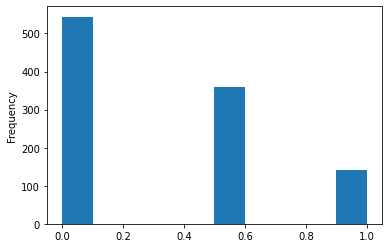

In [10]:
bmi_data['bmi_score'].plot.hist()

## Define triglycerides target:

In [11]:
vo[vo['variable_name'] == 'triglyceride_result_all_m_1']['definition_en']

2152    triglycerides in lithium heparin tube (mmol/l)
Name: definition_en, dtype: object

In [ ]:
vo.groupby('variable_name')['definition_en'].first().to_list()

Very high – over 6 mmol/L

High – between 2 and 6 mmol/L

Borderline high between 1.7 and 2 mmol/L

Normal – below 1.7 mmol/L

In [7]:
trig = blood['triglyceride_result_all_m_1'].groupby(blood.index).max()

In [8]:
trig.name = 'triglyceride'

<Axes: ylabel='Frequency'>

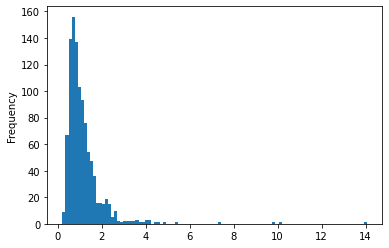

In [15]:
trig.plot.hist(bins=100)

In [9]:
log_trig = trig.apply(lambda x: np.log(x))

<Axes: ylabel='Frequency'>

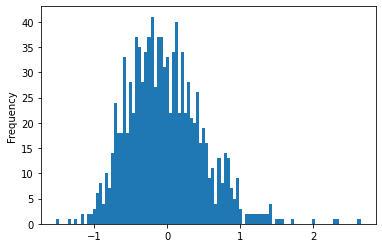

In [10]:
log_trig.plot.hist(bins=100)

In [16]:
(trig < 1.7).sum()

np.int64(906)

In [17]:
(trig >= 1.7).sum()

np.int64(137)

In [18]:
(trig >= 1.7).sum() / (trig.shape[0])

np.float64(0.13122605363984674)

In [19]:
trig_at_risk = trig >= 1.7

## Define hdl target:

In [20]:
m_name = 'hdlchol'
vo[vo['variable_name'] == 'hdlchol_result_all_m_1']['definition_en']

2115    hdl cholesterol in lithium heparin tube (mmol/l)
Name: definition_en, dtype: object

In [21]:
hdl = blood['hdlchol_result_all_m_1'].groupby(blood.index).max()

In [22]:
hdl_risk = pd.concat([hdl.to_frame('hdl'), age_gender['gender']], axis=1)

In [23]:
def define_risk(data):
    if data.gender == 'FEMALE':
        return data.hdl < 1.3 
    elif data.gender == 'MALE':
        return data.hdl < 1.0
    else:
        raise ValueError("Gender must be FEMALE or MALE (non PC im sorry :(" )
hdl_risk['hdl_risk'] = hdl_risk.apply(define_risk, axis=1)

In [24]:
hdl_risk['hdl_risk'].sum()

np.int64(115)

In [25]:
hdl_risk['hdl_risk'].sum() / hdl_risk.shape[0]

np.float64(0.11015325670498084)

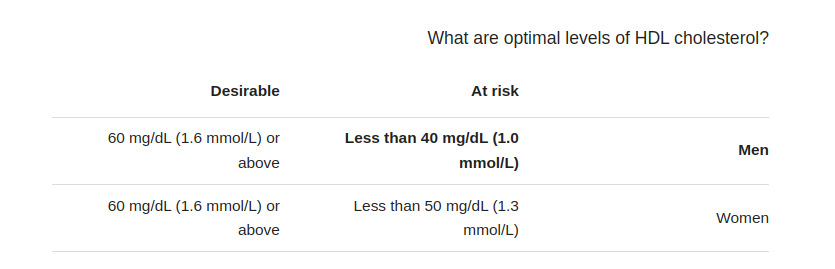

## Visualizations:

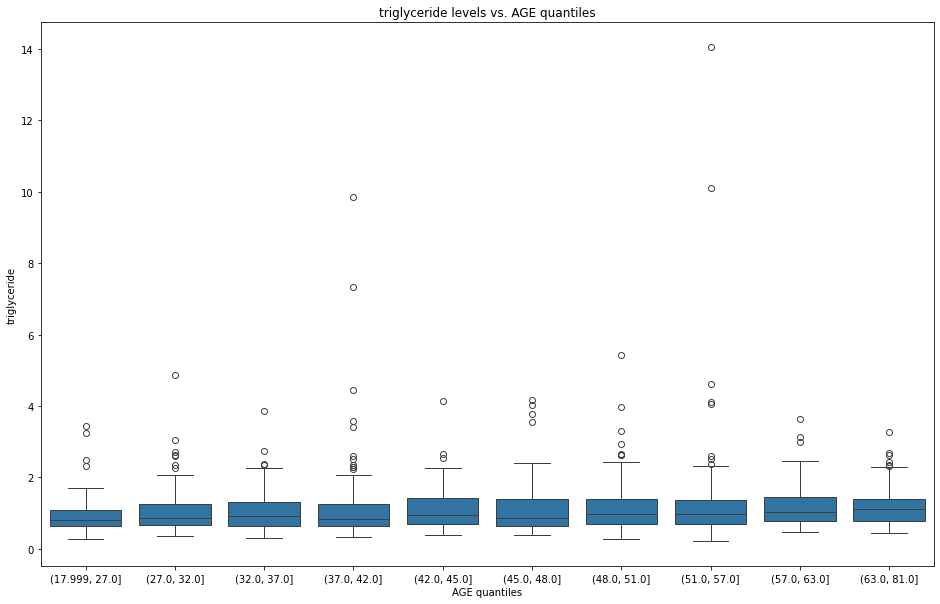

In [26]:
# Let's look on Trig vs. BMI (box plot) and Trig vs. Age (box plot)
# Let's write a quantiled box-plot: 
fig, axes = plt.subplots(figsize=(16, 10))
age_quantiles = pd.qcut(age_gender['age'], q=10)
sns.boxplot(x='AGE quantiles', y='triglyceride', data=pd.DataFrame({'triglyceride':trig, 'AGE quantiles': age_quantiles}))
plt.title('triglyceride levels vs. AGE quantiles')
plt.show()

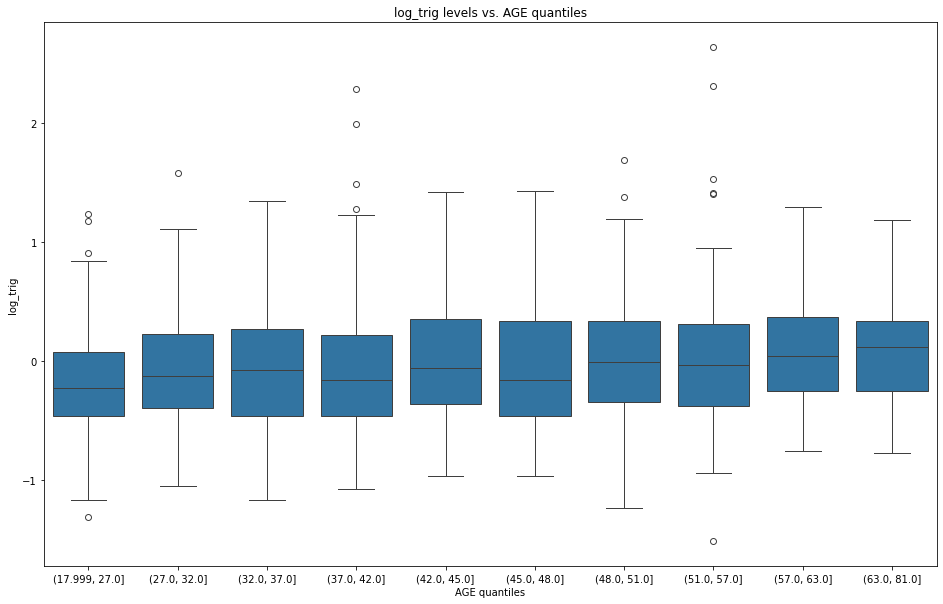

In [11]:
# Let's look on Trig vs. BMI (box plot) and Trig vs. Age (box plot)
# Let's write a quantiled box-plot: 
fig, axes = plt.subplots(figsize=(16, 10))
age_quantiles = pd.qcut(age_gender['age'], q=10)
sns.boxplot(x='AGE quantiles', y='log_trig', data=pd.DataFrame({'log_trig':log_trig, 'AGE quantiles': age_quantiles}))
plt.title('log_trig levels vs. AGE quantiles')
plt.show()

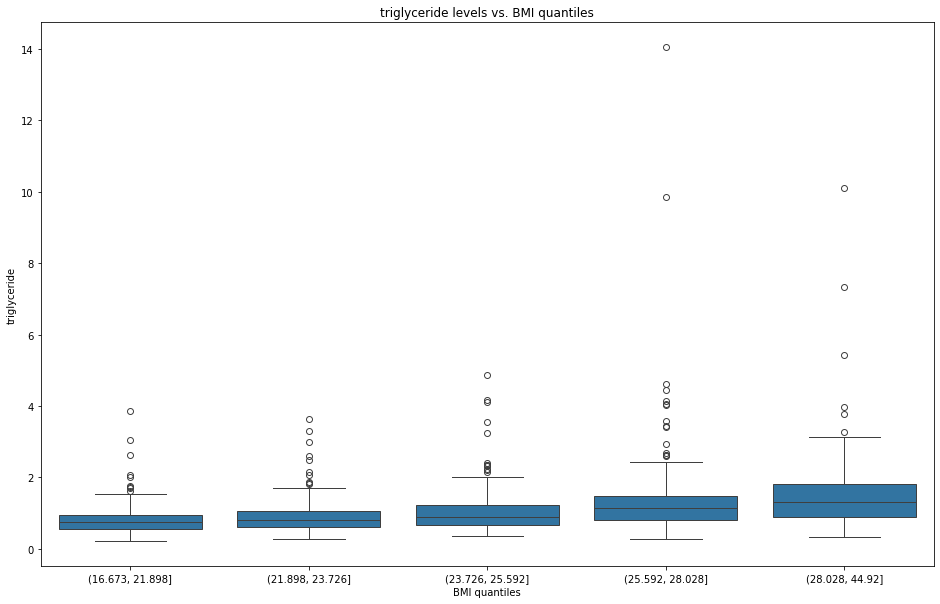

In [27]:
# Let's write a quantiled box-plot: 
fig, axes = plt.subplots(figsize=(16, 10))
bmi_quantiles = pd.qcut(bmi_data['bmi'], q=5)
sns.boxplot(x='BMI quantiles', y='triglyceride', data=pd.DataFrame({'triglyceride':trig, 'BMI quantiles': bmi_quantiles}))
plt.title('triglyceride levels vs. BMI quantiles')
plt.show()


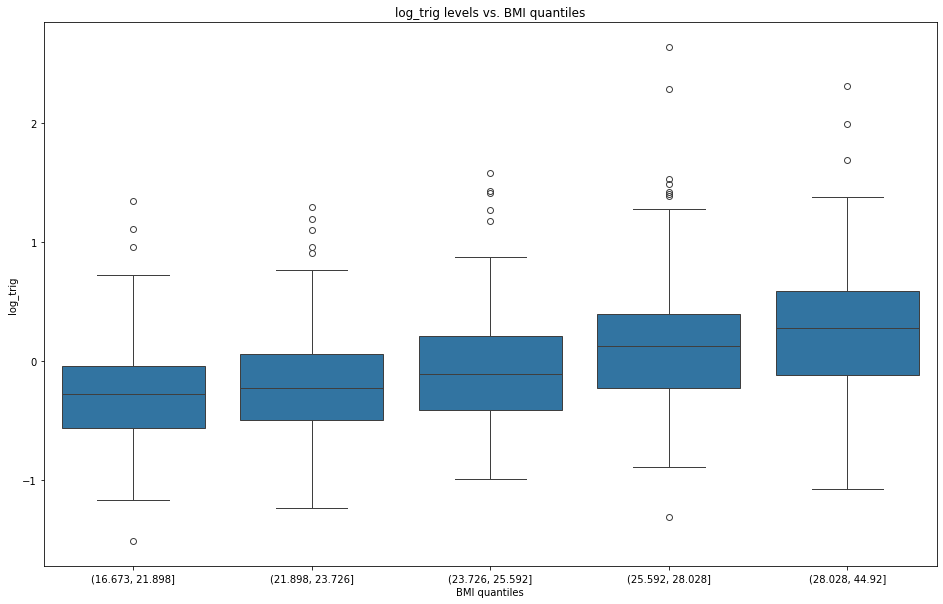

In [13]:
# Let's write a quantiled box-plot: 
fig, axes = plt.subplots(figsize=(16, 10))
bmi_quantiles = pd.qcut(bmi_data['bmi'], q=5)
sns.boxplot(x='BMI quantiles', y='log_trig', data=pd.DataFrame({'log_trig':log_trig, 'BMI quantiles': bmi_quantiles}))
plt.title('log_trig levels vs. BMI quantiles')
plt.show()


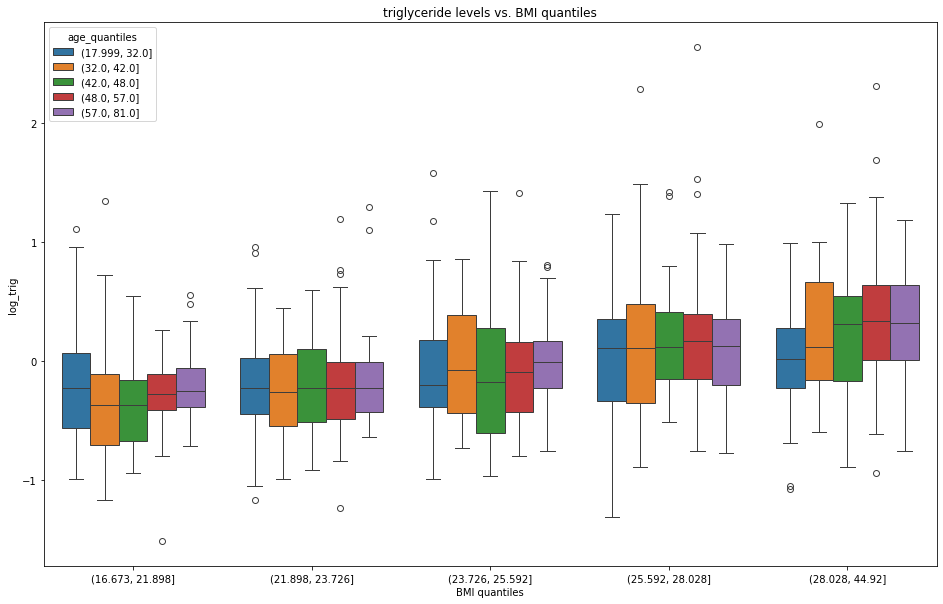

In [15]:
# Let's write a two-levels quantiled box-plot: 
fig, axes = plt.subplots(figsize=(16, 10))
bmi_quantiles = pd.qcut(bmi_data['bmi'], q=5)
age_quantiles = pd.qcut(age_gender['age'], q=5)
sns.boxplot(x='BMI quantiles', y='log_trig', hue='age_quantiles', data=pd.DataFrame({'log_trig':log_trig, 'BMI quantiles': bmi_quantiles, 'age_quantiles': age_quantiles}))
plt.title('triglyceride levels vs. BMI quantiles')
plt.show()

<Axes: xlabel='age_quantiles', ylabel='BMI'>

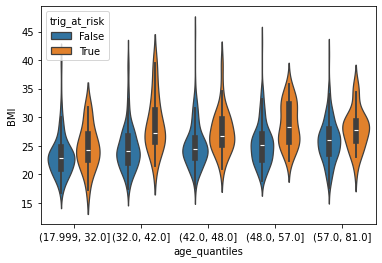

In [29]:
sns.violinplot(data=pd.DataFrame({'trig_at_risk':trig_at_risk, 'BMI': bmi_data['bmi'], 'age_quantiles': age_quantiles}),
               x="age_quantiles", y="BMI", hue="trig_at_risk")

In [30]:
# Trig distribution across genders 
data = pd.concat([trig, age_gender['gender']],axis=1)

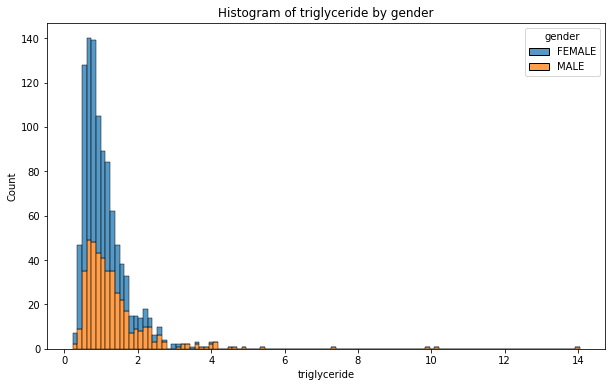

In [31]:
# Plotting using seaborn
fig, axes = plt.subplots(figsize=(10, 6))
sns.histplot(data=data, x='triglyceride', hue='gender', multiple='stack')
plt.title('Histogram of triglyceride by gender')
plt.show()

## Lets try to predict the risk-measures using both micorbiome and age, gender and BMI: 

In [32]:
# Define the target:
y = trig_at_risk

# Define the features:
X = pd.concat([taxonomy_deep, age_gender, bmi_data['bmi'].to_frame()], axis=1)
X['FEMALE'] = X['gender']=='FEMALE'
X=X.drop(columns='gender')
X['FEMALE'] = X['FEMALE'].astype(int)

X, y = X.dropna().align(y.dropna(), join='inner', axis=0)

In [33]:
X

,Ruminiclostridium_E siraeum,CAG-1427 sp000435675,Blautia_A faecis,Tidjanibacter inops_A,Gemmiger qucibialis,Collinsella sp900556515,UMGS1375 sp900066615,Bacteroides intestinigallinarum,Acetatifactor intestinalis,Butyribacter sp003529475,...,Agathobacter rectalis,Prevotella sp003447235,Prevotella sp900546535,Prevotella hominis,Prevotella sp900556795,Cryptobacteroides sp000433355,Limisoma sp000437795,age,bmi,FEMALE
LLDeep_0001,0.033714,9.598449e-05,0.006661,0.000004,0.011214,0.000414,0.003390,0.000088,0.001437,0.000101,...,0.028471,0.000004,0.000488,0.000274,0.000191,0.000042,0.000005,38.0,19.713322,1
LLDeep_0002,0.000001,3.717709e-06,0.006736,0.000000,0.000089,0.000457,0.002402,0.000021,0.000039,0.000138,...,0.011405,0.000173,0.000024,0.000025,0.000000,0.000000,0.000000,18.0,28.713211,0
LLDeep_0006,0.000469,9.306101e-04,0.004121,0.000005,0.012228,0.000660,0.000143,0.000400,0.000292,0.000056,...,0.058814,0.000003,0.001693,0.000354,0.000461,0.000004,0.000012,41.0,30.152747,0
LLDeep_0007,0.001531,1.098414e-05,0.009939,0.001206,0.013773,0.001261,0.001434,0.000490,0.000080,0.000464,...,0.013920,0.000110,0.028257,0.007233,0.026496,0.000009,0.000006,51.0,28.514146,1
LLDeep_0010,0.000005,0.000000e+00,0.081322,0.000004,0.000043,0.000194,0.000103,0.000784,0.000030,0.000071,...,0.000063,0.000002,0.000002,0.000003,0.000009,0.000000,0.000000,25.0,23.030045,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LLDeep_1530,0.000268,3.379735e-07,0.000965,0.000002,0.002461,0.001053,0.014665,0.000126,0.000024,0.000096,...,0.000566,0.000003,0.000013,0.000005,0.000004,0.004771,0.000042,65.0,21.905605,1
LLDeep_1539,0.000145,0.000000e+00,0.002859,0.000321,0.008388,0.000683,0.001001,0.000023,0.000588,0.000018,...,0.002726,0.000000,0.000045,0.000042,0.000010,0.000000,0.001107,59.0,23.710360,0
LLDeep_1542,0.000068,0.000000e+00,0.005481,0.000017,0.029782,0.000942,0.000159,0.000377,0.000559,0.000036,...,0.005758,0.004678,0.000024,0.000091,0.000002,0.000000,0.000008,25.0,23.167430,0
LLDeep_1545,0.000121,1.071376e-04,0.002435,0.000047,0.014437,0.000690,0.001538,0.000128,0.000130,0.000321,...,0.002969,0.000059,0.013127,0.007081,0.005129,0.003435,0.000062,56.0,22.791291,0


In [34]:
# For now (dev only) lets do train, test splits: 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [35]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

y_pred_proba_train = clf.predict_proba(X_train)
y_pred_proba_test = clf.predict_proba(X_test)

y_pred_train = pd.Series(y_pred_train, index=X_train.index)
y_pred_test = pd.Series(y_pred_test, index=X_test.index)

In [36]:
y_pred_train.unique()

array([ True, False])

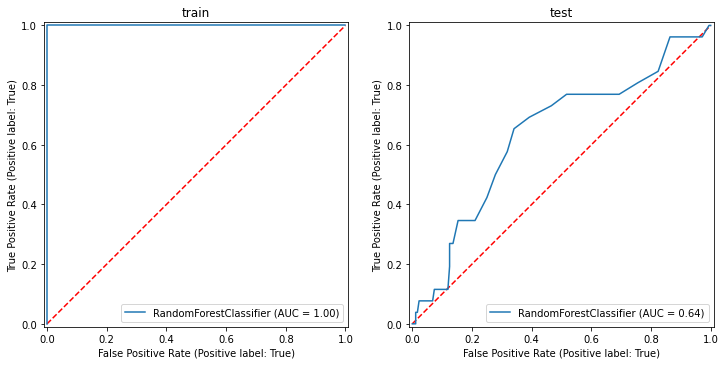

In [37]:
# ROC curve:
from sklearn.metrics import RocCurveDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')
axes[1].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')

RocCurveDisplay.from_estimator(clf, X_train, y_train, ax=axes[0])
axes[0].set_title('train')

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=axes[1])
axes[1].set_title('test')
plt.show()

In [38]:
from sklearn.metrics import classification_report
res = classification_report(y_true=y_test , y_pred=y_pred_test)
print(res)

              precision    recall  f1-score   support

       False       0.87      1.00      0.93       176
        True       0.00      0.00      0.00        26

    accuracy                           0.87       202
   macro avg       0.44      0.50      0.47       202
weighted avg       0.76      0.87      0.81       202



/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/noamark/Human2Dogs/noa_h2d/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/noamark/Human2Dogs/noa_h2d/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/noamark/Human2Dogs/noa_h2d/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precis

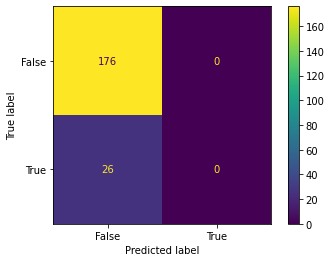

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

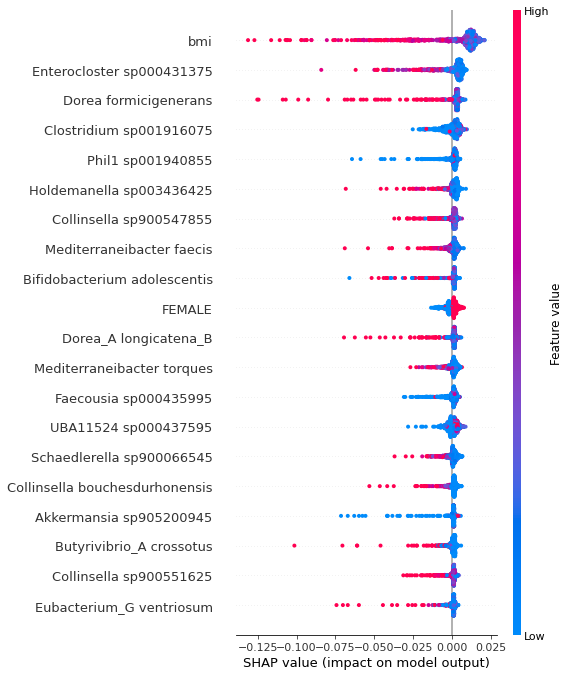

In [40]:
# Feature importance using SHAP values: 
from shap import Explainer, summary_plot
plt.subplots(figsize=(16,12))
# calculate shap values of the RF over the test set:
# 1. Visualize the Shapley values using a summary plot. How do they compare to ALE plots?
explainer = Explainer(clf)
shap_values = explainer.shap_values(X_train)
summary_plot(shap_values[:,:,0], X_train)

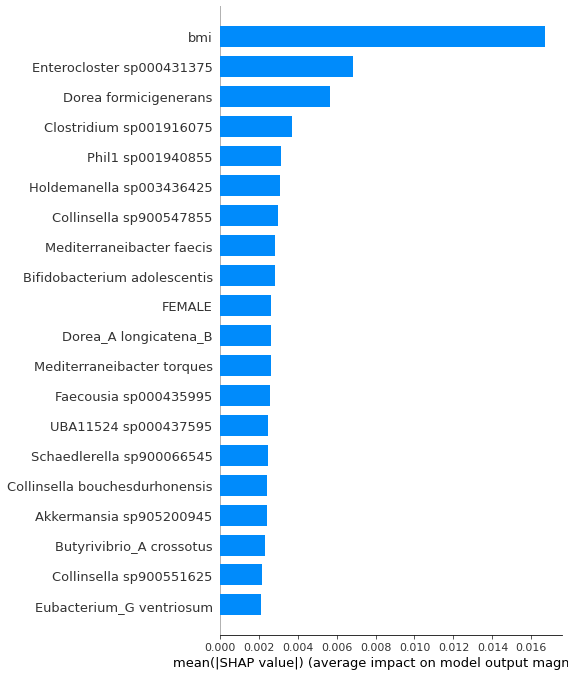

In [41]:
# summary_plot(shap_values[:,:,0], X_train)
summary_plot(shap_values = shap_values[:,:,0],features = X_train, plot_type="bar")


In [42]:
X_train.shape

(808, 308)

In [43]:
shap_values[:,:,0].shape

(808, 308)

In [44]:
mean_shap_values = pd.DataFrame(shap_values[:,:,0], columns=X_train.columns, index=X_train.index).abs().mean()

In [45]:
top_ten_species = mean_shap_values.sort_values(ascending=False).drop(['bmi', 'age', 'FEMALE'])[:10].index

In [46]:
X_train.loc[:, top_ten_species].mean()

Enterocloster sp000431375       0.000931
Dorea formicigenerans           0.004086
Clostridium sp001916075         0.000804
Phil1 sp001940855               0.001063
Holdemanella sp003436425        0.000897
Collinsella sp900547855         0.001075
Mediterraneibacter faecis       0.008065
Bifidobacterium adolescentis    0.020007
Dorea_A longicatena_B           0.006019
Mediterraneibacter torques      0.002628
dtype: float64

<Axes: >

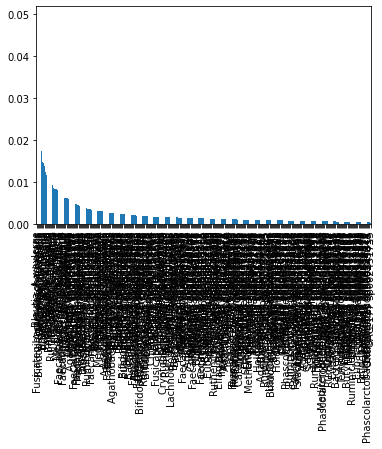

In [47]:
X_train.drop(columns=['age','bmi', 'FEMALE']).mean().sort_values(ascending=False).plot.bar()

In [48]:
X_train.drop(columns=['age','bmi', 'FEMALE']).mean().sort_values(ascending=False)[:20]

Blautia_A wexlerae                 0.049473
Fusicatenibacter saccharivorans    0.023964
Agathobacter rectalis              0.021940
Bifidobacterium adolescentis       0.020007
Gemmiger qucibialis                0.017421
Agathobacter faecis                0.014814
Blautia_A sp900066335              0.014563
Dorea_A longicatena                0.013747
Ruminococcus_E bromii              0.012258
Blautia_A wexlerae_B               0.011710
Blautia_A obeum                    0.011095
Anaerobutyricum hallii             0.011017
Bifidobacterium longum             0.009884
Ruminococcus_E bromii_B            0.009734
Bariatricus comes                  0.009234
Phocaeicola vulgatus               0.008522
Anaerostipes hadrus                0.008272
Gemmiger formicilis                0.008266
Blautia_A massiliensis             0.008224
Mediterraneibacter faecis          0.008065
dtype: float64

In [49]:
# out of the top-10 species, instead of looking on the RA size lets look on the non-zero RA and the distribution / std (with respect to the mean)
(X_train.loc[:, top_ten_species] != 0 ).sum() / X_train.shape[0]

Enterocloster sp000431375       1.000000
Dorea formicigenerans           1.000000
Clostridium sp001916075         0.960396
Phil1 sp001940855               1.000000
Holdemanella sp003436425        0.977723
Collinsella sp900547855         1.000000
Mediterraneibacter faecis       1.000000
Bifidobacterium adolescentis    1.000000
Dorea_A longicatena_B           1.000000
Mediterraneibacter torques      1.000000
dtype: float64

In [50]:
((X_train.drop(columns=['age','bmi', 'FEMALE']) > 0.00001).sum() / X_train.shape[0]).sort_values(ascending=False)

Blautia_A obeum                            1.000000
Ruminococcus_E bromii                      1.000000
Dorea_A longicatena                        1.000000
Onthomonas sp900758315                     1.000000
Copromorpha sp900549125                    1.000000
                                             ...   
Phascolarctobacterium_A succinatutens_A    0.298267
Phascolarctobacterium faecium              0.287129
Monoglobus pectinilyticus                  0.280941
Limisoma sp000437795                       0.235149
Cryptobacteroides sp000433355              0.185644
Length: 305, dtype: float64

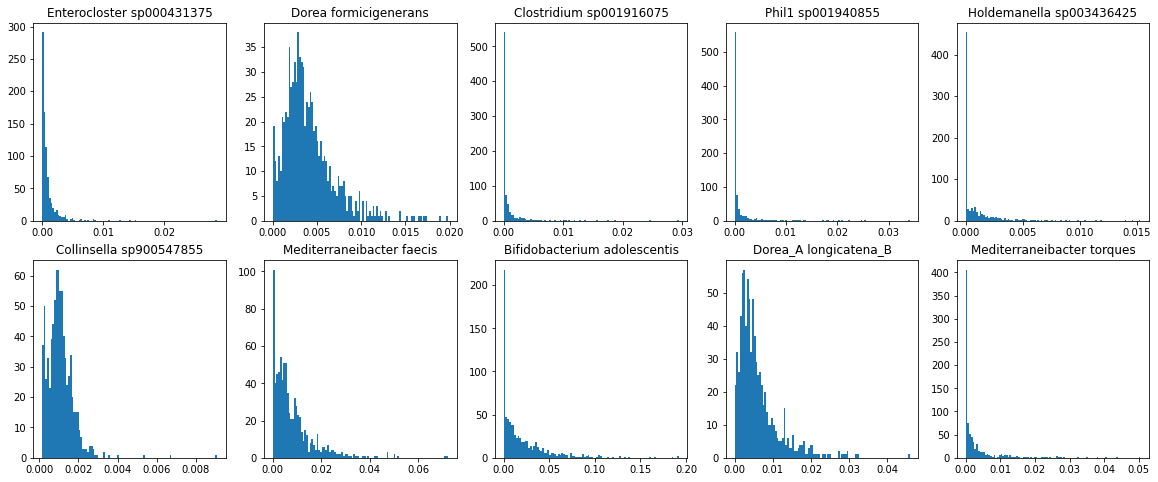

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8))

for i, taxa_name in enumerate(top_ten_species):
    r = int(i / 5)
    c = i % 5
    axes[r][c].hist(X_train[taxa_name], bins=100)
    axes[r][c].set_title(taxa_name)

    

So, we check if the top 10 features are rare. We need to note, that the taxa is really deep, so the RA values are small and with very long tail. 

In [52]:
# TODO:
# Let's use cross validation and try to avoid overfitting 
# Let's deal with the imbalance distribution 


# Let's manually adjust the parameters to avoid overfitting
# Let's try to select harder threshold for rare-specises 
# Let's try to do some feature generartion: abundance/ prevelance of not-to-rare features + alpha-diversity within clades + alpha-diversity of the sample?
# What about prior knowledge on clased/ species/ families that metter? 

# Let's let it predict only from age, gender, bmi and alpha-diversity:
# Let's do two-stage prediction, first predict only from bmi and gender, and then from the rest? / let's normalize according to bmi and gender? 

# TODO: plot the SHAP value of specific samples? (what was the desicion process? and other plots? dive deeper?)

## Lets try to predict the risk-measures - hyper-parameter tuning

In [ ]:
# Let's use cross validation and try to avoid overfitting 

from sklearn.model_selection import GridSearchCV
random_forest = RandomForestClassifier(verbose = 1)
param_grid = {'n_estimators': [50, 100],
              'max_depth': [None, 3, 10],
              'min_samples_split': [2, 10],
   'max_features': ['sqrt', 'log2']}

search = GridSearchCV(random_forest, param_grid, cv=5, scoring='roc_auc')
search.fit(X_train, y_train)

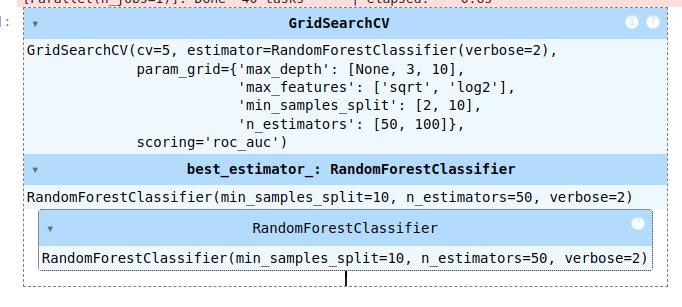

In [54]:
search.best_params_

{'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 100}

In [55]:
clf = RandomForestClassifier(random_state=42, max_depth=None, max_features='sqrt', min_samples_split=10, n_estimators=50)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

y_pred_proba_train = clf.predict_proba(X_train)
y_pred_proba_test = clf.predict_proba(X_test)

y_pred_train = pd.Series(y_pred_train, index=X_train.index)
y_pred_test = pd.Series(y_pred_test, index=X_test.index)

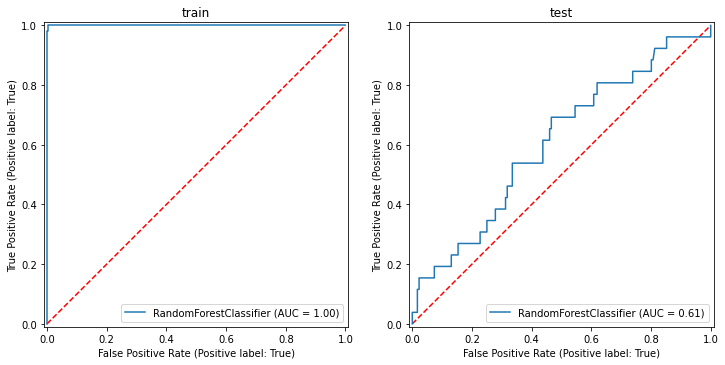

In [56]:
# ROC curve:
from sklearn.metrics import RocCurveDisplay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')
axes[1].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')

RocCurveDisplay.from_estimator(clf, X_train, y_train, ax=axes[0])
axes[0].set_title('train')

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=axes[1])
axes[1].set_title('test')
plt.show()

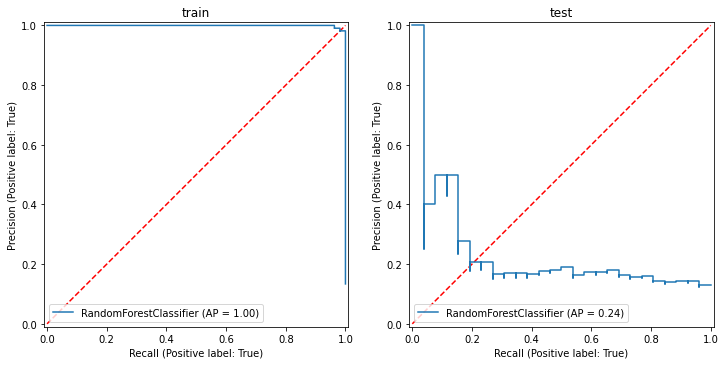

In [57]:
# Precision-Recall Curve:
from sklearn.metrics import PrecisionRecallDisplay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')
axes[1].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')

PrecisionRecallDisplay.from_estimator(clf, X_train, y_train, ax=axes[0])
axes[0].set_title('train')

PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=axes[1])
axes[1].set_title('test')
plt.show()


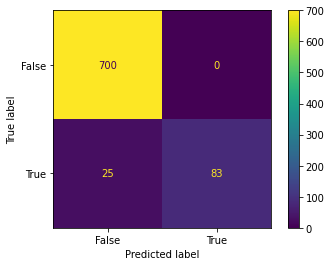

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)

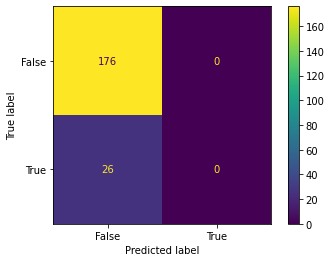

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

## Lets try to predict the risk-measures - hyper-parameter tuning + accounting for imbalanced data

### Using stratified split:

To account for the imbalanced data:
1. First we need to split the train/test using stratified split, so we will have a "fair" representation of positive/negative. We need to do the same for the cross validation, using grouped cross validation instead of regular k fold.
2. Second, we need to choose the evaluation matrix smart, I have tried auc_roc, let's tree 'recall'. 
3. Try to use the class_weight parameter in RandomForest to adjust for imbalance?
(4. Try to use random undersampling or oversampling from imblearn library?  - low priority)

In [60]:
(y_train == 1).sum() / y_train.shape

array([0.13366337])

In [61]:
(y_test == 1).sum() / y_train.shape

array([0.03217822])

In [62]:
# First let's split again the train and test feature and target:

# Define the target:
y = trig_at_risk

# Define the features:
X = pd.concat([taxonomy_deep, age_gender, bmi_data['bmi'].to_frame()], axis=1)
X['FEMALE'] = X['gender']=='FEMALE'
X=X.drop(columns='gender')
X['FEMALE'] = X['FEMALE'].astype(int)

X, y = X.dropna().align(y.dropna(), join='inner', axis=0)

In [63]:
# For now (dev only) lets do train, test splits: 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [64]:
# sanity checks:
print(y_train.sum() / y_train.shape[0])
print(y_test.sum() / y_test.shape[0])

0.13242574257425743
0.13366336633663367


In [65]:
# Let's use cross validation and try to avoid overfitting 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


random_forest = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [50, 100],
              'max_depth': [None, 3, 10],
              'min_samples_split': [2, 10],
   'max_features': ['sqrt', 'log2']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

search = GridSearchCV(random_forest, param_grid, cv=cv, scoring='recall')
search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 3, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 10],
                         'n_estimators': [50, 100]},
             scoring='recall')

In [66]:
search.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 100}

In [67]:
clf = RandomForestClassifier(random_state=42, **search.best_params_)
clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, random_state=42)

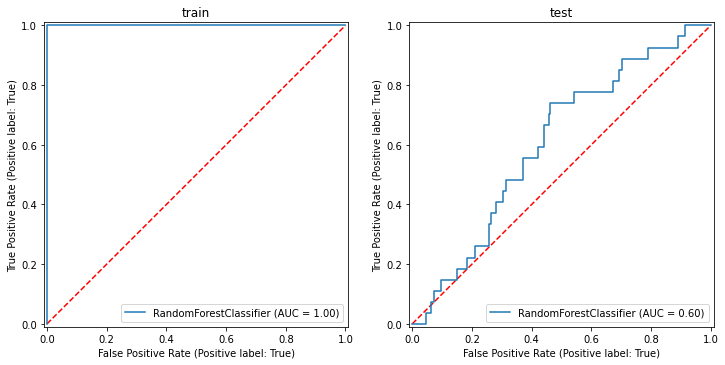

In [68]:
# ROC curve:
from sklearn.metrics import RocCurveDisplay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')
axes[1].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')

RocCurveDisplay.from_estimator(clf, X_train, y_train, ax=axes[0])
axes[0].set_title('train')

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=axes[1])
axes[1].set_title('test')
plt.show()

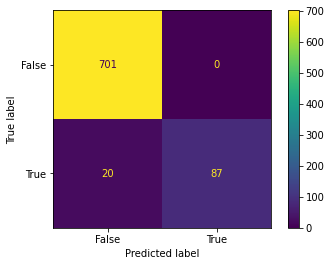

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)

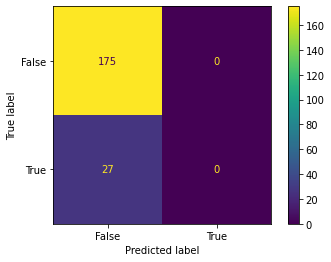

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

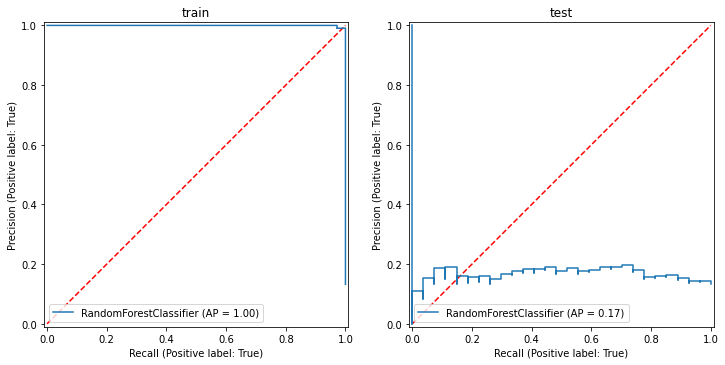

In [71]:
# Precision-Recall Curve:
from sklearn.metrics import PrecisionRecallDisplay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')
axes[1].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')

PrecisionRecallDisplay.from_estimator(clf, X_train, y_train, ax=axes[0])
axes[0].set_title('train')

PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=axes[1])
axes[1].set_title('test')
plt.show()


### starified split + class_weight parameter:

In [72]:
# Let's try now to use class_weight parameter:
# class_weight = 'balanced'

clf = RandomForestClassifier(class_weight = 'balanced', random_state=42, max_depth=None, max_features='sqrt', min_samples_split=10, n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       random_state=42)

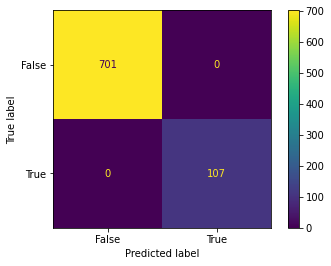

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)

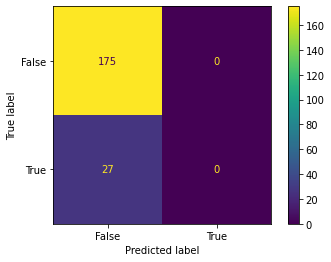

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

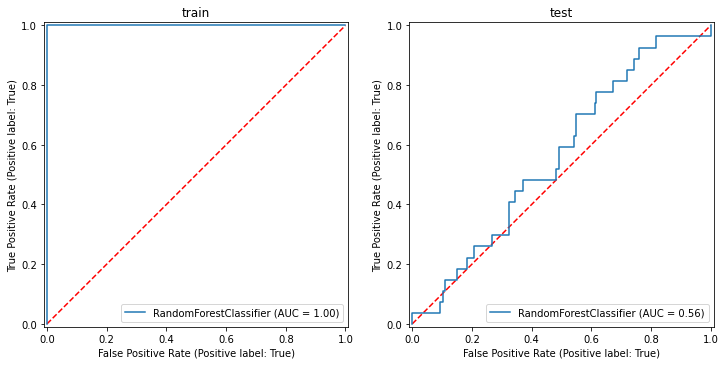

In [75]:
# ROC curve:
from sklearn.metrics import RocCurveDisplay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')
axes[1].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')

RocCurveDisplay.from_estimator(clf, X_train, y_train, ax=axes[0])
axes[0].set_title('train')

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=axes[1])
axes[1].set_title('test')
plt.show()

To summarize, the effort to adjust model selection and tune hyper-parameter didn't yeild improvement in the result. 
We will try to resort back to feature-engenring, two-steps prediction and normalizing the target. 

Nevertheless, we ajust our pipeline and therefore suggest the processes for the next model training:
1. Select hyper-parameter using Grid search and RepeatedStratifiedKFold accounting for class-imbalance, select roc-auc as the score, on stratified training set. Then retrain on all X_train and evaluate on y_train. Account for class_weight parameter in the grid search. 
2. Train and predict on all the data using cross validation. 

In [ ]:
# The pipeline: 

# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedStratifiedKFold


# random_forest = RandomForestClassifier(random_state=42)
# param_grid = {'n_estimators': [50, 100],
#               'max_depth': [None, 3, 10],
#               'min_samples_split': [2, 10],
#    'max_features': ['sqrt', 'log2'],
#              'class_weight': [None, 'balanced', 'balanced_subsample']}

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# search = GridSearchCV(random_forest, param_grid, cv=cv, scoring='roc_auc')
# search.fit(X_train, y_train)

# print(search.best_params_)

# clf = RandomForestClassifier(random_state=42, **search.best_params_)
# clf.fit(X_train, y_train)

### Let's create a model with small subset of features 

Instead of looking on the relative abundance feature table, which is large and complext, let's try to predict based on a few features:
BMI, Gender, Age, Alpha-diversity

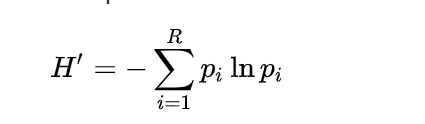

In [78]:
def sample_shannon_diversity(relative_abundance):
    """
        Shannon diversity calculate: given pi is the vector of relative abundance of speices i in the sample then the sample shannon diversity index is the entopy aka:
        - \sum_i pi*ln(pi)
    """
    if type(relative_abundance) != pd.Series:
        raise ValueError("Input should be pd.Series, a sample")
    if not ((relative_abundance >= 0).all() & (relative_abundance.sum() <=1)):
        raise ValueError("Sample shannon diversity expect the data to be relative abundance.")
    return -(relative_abundance * relative_abundance.apply(lambda x: np.log(x) if x != 0 else 0)).sum()


In [79]:
shannon_diversity = taxonomy_deep.apply(sample_shannon_diversity, axis=1)

In [80]:
def sample_richness(relative_abundance):
    """ number of non-zero taxa """
    return (relative_abundance != 0).sum()

In [81]:
richness = taxonomy_deep.apply(sample_richness, axis=1)

<Axes: ylabel='Frequency'>

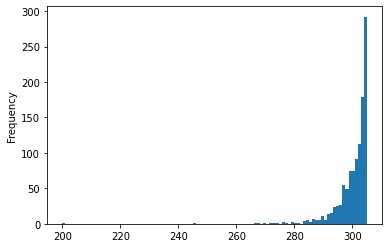

In [82]:
richness.plot.hist(bins=100)

<Axes: ylabel='Frequency'>

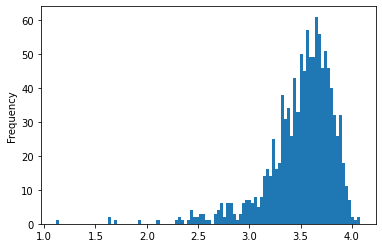

In [83]:
shannon_diversity.plot.hist(bins=100)

In [120]:
# First let's split again the train and test feature and target:

# Define the target:
y = trig_at_risk

# Define the features:
X = pd.concat([shannon_diversity.to_frame('shannon_diversity'), richness.to_frame('richness'), age_gender, bmi_data['bmi'].to_frame()], axis=1)
X['FEMALE'] = X['gender']=='FEMALE'
X=X.drop(columns='gender')
X['FEMALE'] = X['FEMALE'].astype(int)

X, y = X.dropna().align(y.dropna(), join='inner', axis=0)

In [121]:
X.head()

,shannon_diversity,richness,age,bmi,FEMALE
LLDeep_0001,3.362692,305.0,38.0,19.713322,1
LLDeep_0002,3.204111,287.0,18.0,28.713211,0
LLDeep_0006,3.289602,303.0,41.0,30.152747,0
LLDeep_0007,3.534502,304.0,51.0,28.514146,1
LLDeep_0010,2.568320,300.0,25.0,23.030045,1


In [122]:
from sklearn.model_selection import train_test_split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [124]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_clf, y_train_clf)

RandomForestClassifier(random_state=42)

In [125]:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


random_forest = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 3, 10],
              'min_samples_split': [2, 10, 50],
   'max_features': ['sqrt', 'log2'],
             'class_weight': [None, 'balanced', 'balanced_subsample']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

search = GridSearchCV(random_forest, param_grid, cv=cv, scoring='roc_auc')
search.fit(X_train_clf, y_train_clf)

print(search.best_params_)

clf = RandomForestClassifier(random_state=42, **search.best_params_)
clf.fit(X_train_clf, y_train_clf)

{'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 50}


RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=50, n_estimators=50, random_state=42)

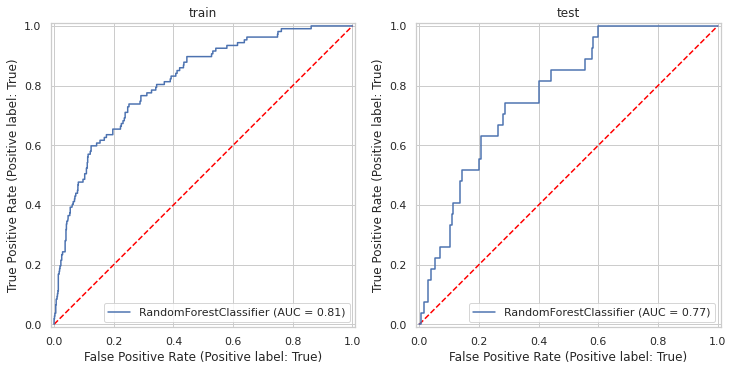

In [126]:
# ROC curve:
from sklearn.metrics import RocCurveDisplay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')
axes[1].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')

RocCurveDisplay.from_estimator(clf, X_train_clf, y_train_clf, ax=axes[0])
axes[0].set_title('train')

RocCurveDisplay.from_estimator(clf, X_test_clf, y_test_clf, ax=axes[1])
axes[1].set_title('test')
plt.show()

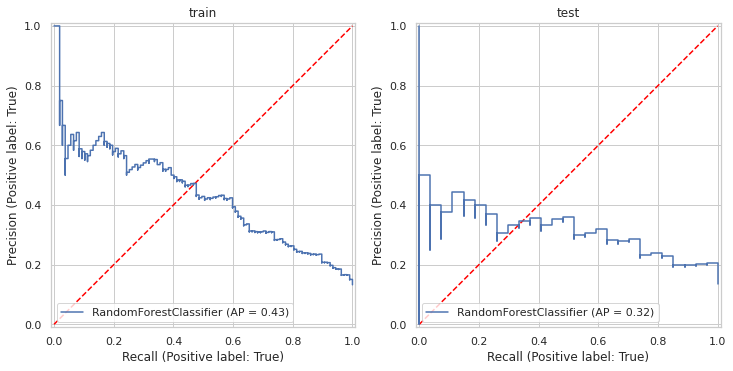

In [127]:
# Precision-Recall Curve:
from sklearn.metrics import PrecisionRecallDisplay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')
axes[1].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')

PrecisionRecallDisplay.from_estimator(clf, X_train_clf, y_train_clf, ax=axes[0])
axes[0].set_title('train')

PrecisionRecallDisplay.from_estimator(clf, X_test_clf, y_test_clf, ax=axes[1])
axes[1].set_title('test')
plt.show()

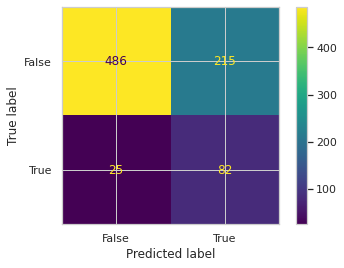

In [128]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_train_clf, y_train_clf)

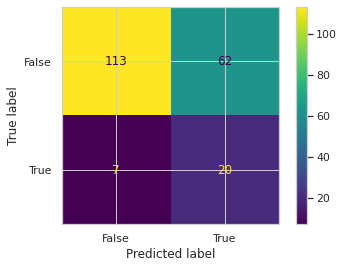

In [129]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test_clf, y_test_clf)

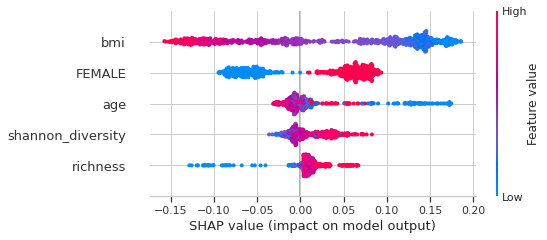

In [130]:
# Feature importance using SHAP values: 
from shap import Explainer, summary_plot
plt.subplots(figsize=(16,12))
# calculate shap values of the RF over the test set:
# 1. Visualize the Shapley values using a summary plot. How do they compare to ALE plots?
explainer = Explainer(clf)
shap_values = explainer.shap_values(X_train_clf)
summary_plot(shap_values[:,:,0], X_train_clf)

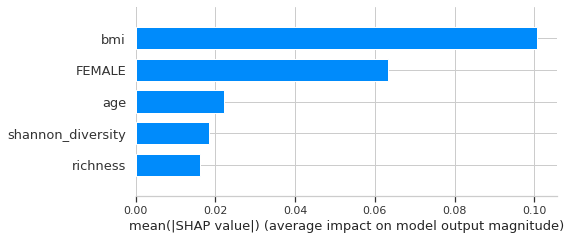

In [131]:
# summary_plot(shap_values[:,:,0], X_train)
summary_plot(shap_values = shap_values[:,:,0],features = X_train_clf, plot_type="bar")


## Predictor base line using only BMI, Gender and age:

#### vis:

In [132]:
y = trig

In [133]:
y.name

'triglyceride'

In [17]:
X = pd.concat([ age_gender['gender'].to_frame() , bmi_data['bmi'].to_frame()], axis=1)
X['FEMALE'] = X['gender']=='FEMALE'
X=X.drop(columns='gender')
X['FEMALE'] = X['FEMALE'].astype(int)

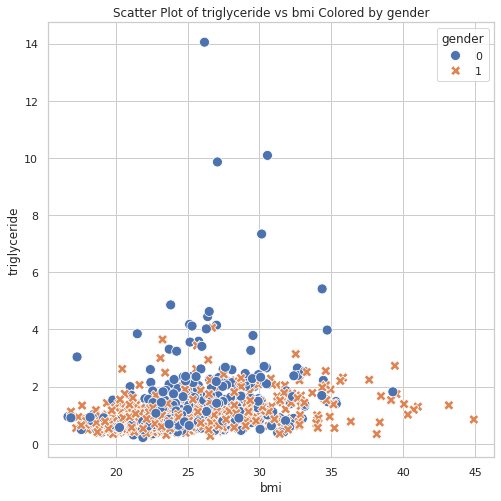

In [135]:
# Let's create a scatter plot showing trig vs. bmi colored by gender:

sns.set(style='whitegrid')

# Create the scatter plot
plt.figure(figsize=(8, 8))
scatter_plot = sns.scatterplot(data=pd.concat([y.to_frame(), X],axis=1), x='bmi', y='triglyceride', hue='FEMALE', style='FEMALE', s=100)

# Adding title and labels
scatter_plot.set_title('Scatter Plot of triglyceride vs bmi Colored by gender')
scatter_plot.set_xlabel('bmi')
scatter_plot.set_ylabel('triglyceride')

# Show the plot
plt.legend(title='gender')
plt.show()

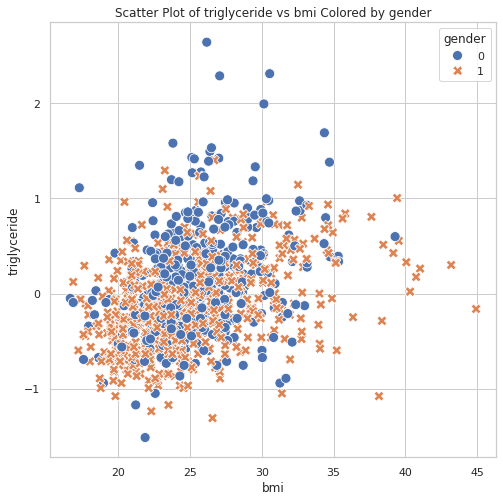

In [19]:
# Let's create a scatter plot showing trig vs. bmi colored by gender:

sns.set(style='whitegrid')

# Create the scatter plot
plt.figure(figsize=(8, 8))
scatter_plot = sns.scatterplot(data=pd.concat([log_trig.loc[X.index].to_frame('log_trig'), X],axis=1), x='bmi', y='log_trig', hue='FEMALE', style='FEMALE', s=100)

# Adding title and labels
scatter_plot.set_title('Scatter Plot of triglyceride vs bmi Colored by gender')
scatter_plot.set_xlabel('bmi')
scatter_plot.set_ylabel('triglyceride')

# Show the plot
plt.legend(title='gender')
plt.show()

In [136]:
# sns.violinplot(data=pd.concat([y.to_frame(), X],axis=1), x='bmi', y='triglyceride', hue='FEMALE')

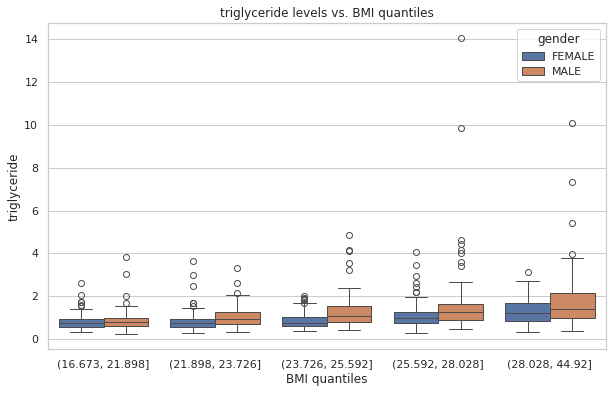

In [137]:
# Let's write a two-levels quantiled box-plot: 
fig, axes = plt.subplots(figsize=(10, 6))
bmi_quantiles = pd.qcut(bmi_data['bmi'], q=5)
sns.boxplot(x='BMI quantiles', y='triglyceride', hue='gender', data=pd.DataFrame({'triglyceride':trig, 'BMI quantiles': bmi_quantiles, 'gender': age_gender['gender']}))
plt.title('triglyceride levels vs. BMI quantiles')
plt.show()

#### train:

In [138]:
# Let's first create a base line using only BMI and Gender. Try both Random Forest and Logistic regression:
# First let's split again the train and test feature and target:

# Define the target:
y = trig_at_risk

# Define the features:
X = pd.concat([age_gender, bmi_data['bmi'].to_frame()], axis=1)
X['FEMALE'] = X['gender']=='FEMALE'
X=X.drop(columns='gender')
X['FEMALE'] = X['FEMALE'].astype(int)

X, y = X.dropna().align(y.dropna(), join='inner', axis=0)

In [139]:
from sklearn.model_selection import train_test_split
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [141]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


random_forest = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 3, 10],
              'min_samples_split': [2, 10, 50],
   'max_features': ['sqrt', 'log2'],
             'class_weight': [None, 'balanced', 'balanced_subsample']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

search = GridSearchCV(random_forest, param_grid, cv=cv, scoring='roc_auc')
search.fit(X_train_baseline, y_train_baseline)

print(search.best_params_)

base_line_clf = RandomForestClassifier(random_state=42, **search.best_params_)
base_line_clf.fit(X_train_baseline, y_train_baseline)

{'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 100}


RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=50, random_state=42)

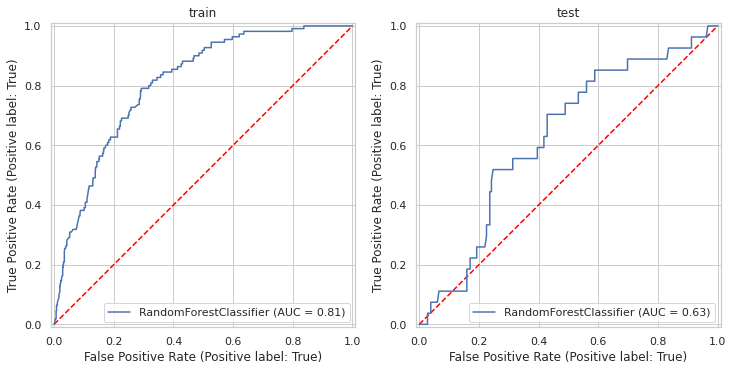

In [142]:
# ROC curve:
from sklearn.metrics import RocCurveDisplay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')
axes[1].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')

RocCurveDisplay.from_estimator(base_line_clf, X_train_baseline, y_train_baseline, ax=axes[0])
axes[0].set_title('train')

RocCurveDisplay.from_estimator(base_line_clf, X_test_baseline, y_test_baseline, ax=axes[1])
axes[1].set_title('test')
plt.show()

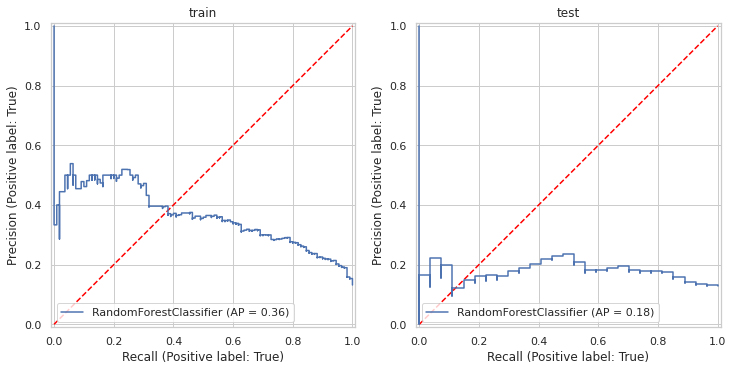

In [143]:
# Precision-Recall Curve:
from sklearn.metrics import PrecisionRecallDisplay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')
axes[1].plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='--', color='red')

PrecisionRecallDisplay.from_estimator(base_line_clf, X_train_baseline, y_train_baseline, ax=axes[0])
axes[0].set_title('train')

PrecisionRecallDisplay.from_estimator(base_line_clf, X_test_baseline, y_test_baseline, ax=axes[1])
axes[1].set_title('test')
plt.show()

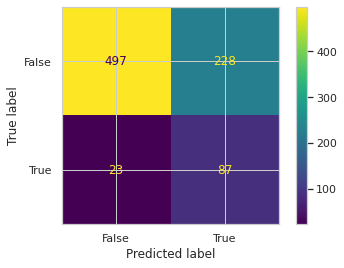

In [144]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(base_line_clf, X_train_baseline, y_train_baseline)

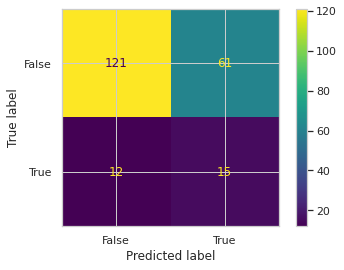

In [145]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(base_line_clf, X_test_baseline, y_test_baseline)

In [146]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report


train_index = y_train.index.intersection(y_train_clf.index)
test_index = y_test.index.intersection(y_test_clf.index)


y_pred_proba_train = pd.Series(clf.predict_proba(X_train_clf)[:, 1], index=X_train_clf.index)
y_pred_proba_test = pd.Series(clf.predict_proba(X_test_clf)[:, 1], index=X_test_clf.index)

base_line_proba_train = pd.Series(base_line_clf.predict_proba(X_train_baseline)[:, 1], index=X_train_baseline.index)
base_line_proba_test  = pd.Series(base_line_clf.predict_proba(X_test_baseline)[:, 1], index=X_test_baseline.index)

clf_train_roc_auc = roc_auc_score(y_true=y_train.loc[train_index], y_score=y_pred_proba_train.loc[train_index])
base_line_train_roc_auc = roc_auc_score(y_true=y_train.loc[train_index], y_score=base_line_proba_train.loc[train_index])

clf_test_roc_auc = roc_auc_score(y_true=y_test.loc[test_index], y_score=y_pred_proba_test.loc[test_index])
base_line_test_roc_auc = roc_auc_score(y_true=y_test.loc[test_index], y_score=base_line_proba_test.loc[test_index])

print(f"clf TRAIN ROC AUC: {round(clf_train_roc_auc, 2)} vs base-line {round(base_line_train_roc_auc, 2)}")
print(f"clf TEST ROC AUC: {round(clf_test_roc_auc, 2)} vs base-line {round(base_line_test_roc_auc, 2)}")


clf TRAIN ROC AUC: 0.82 vs base-line 0.79
clf TEST ROC AUC: 0.67 vs base-line 0.72


### Summarise:

Comparing the baseline preformance, to the most simplest model that uses gut microbiome information:
* Looking on the ROC curve it does seems like the gut-data improve - but we don't compare apples to apples, as the sampled are not the same (we dropped samples with nan values)
* Looking on the roc_auc computed using the exact same samples - it seems like it didn't improve. 

Can we enginue our feature in a way that will improve the prediction compare to the base-line? (can we create better base line?)
It is possible that it is really hard task (not sure the published article is sure of this possibility) 

Can we create a comparable model using only gut data? 

In [ ]:
# Let's see how much we can improve above it using gut-data 